# FINAL PROJECT
## K. Lionel Tukei

In the final project, you will create a closed loop system for an SBML model.
Start by selecting a model from the [BioModels Curated branch](https://www.ebi.ac.uk/biomodels/search?query=*%3A*+AND+curationstatus%3A%22Manually+curated%22&domain=biomodels).)
You don't have to restrict yourself to thoses models, but you'll find that the curated BioModels are fairly easy to reproduce.) You'll find a paper associated with each model.

1. **Specify the requirements for the control system.** (10 pt) After reading the paper for the model, propose a chemical species for the control output
and an operating point for it. You should also indicate the desired
operating characteristics such as settling time and overshoot.
Justify this in terms of the potential value of controlling
the chemical species and why the particular operating point makes sense.
1. **Determine the control input you will use**. (10 pt) This will require evaluating the DC gain of
of candidate control inputs on chemical species that are the control outputs.
1. **Design the control system**. (15 pt) You will specify a controller and possibly a filter.
You will select the parameters of the elements based on the poles and DC gains implied by
the operating characteristics in (1).
1. **Evaluate your design.** (25 pt) You will construct a simulation testbed in which the
SBML model is regulated by your control architecture.
You should evaluate the effects of disturbances and noise.
1. **Discuss trade-offs.** (10 pt) Discuss trade-offs in the selection of parameter values in your design.
This should consider the impact of parameter values on the closed loop transfer functions.

You will receive 5 extra points if you use LaTex for your mathematical analyses.

# Preliminaries

In [ ]:
!pip install -q controlSBML
import controlSBML as ctl

import control
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te

# Helpful Hints

## LaTex Basics

1. All LaTex appears between dollar signs (``$``)
1. Subscripts: $x_2$
1. Superscript: $x^2$
1. Summation: $\sum_{n=0}^{\infty} e^{nt}$
1. Derivatives: $\dot{x}(t)$
1. Bold: ${\bf A}$
1. Fractions: $\frac{a}{b}$

## Closed Loop Transfer Functions

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

# 1. Specify Requirements

## Helper Funtions

In [17]:
TIMES = ctl.makeSimulationTimes(0, 5, 50)

In [18]:
def plotTFs(Gs, kp=0, ki=0, kd=0, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


In [19]:
def makeHRY(model, input_name, output_name, time=0, kp=0, ki=0, kd=0):
    """
    Calculates the transfer function from the reference input to the output.
    
    Parameters
    ----------
    model: str
    input_name: str
    output_name: str
    time: float
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    control.TransferFunction
    """
    ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
    Gs = ctlsb.makeTransferFunction(time=time)
    dct = plotTFs(Gs, kp=kp, ki=ki, kd=kd, is_plot=False)
    return dct["HRYs"]
    
    
# TESTS
BioMod = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000733.3?filename=Moore_2004_fig6.xml"
tf = makeHRY(BioMod, "eff_Tcells", "tumor_cells", kp=0)
assert(tf.dcgain() == 0)
print("OK!")

OK!


## Specifications 

**The model that will be used is:**
Moore_2004_Mathematical model for CML and T cell interaction

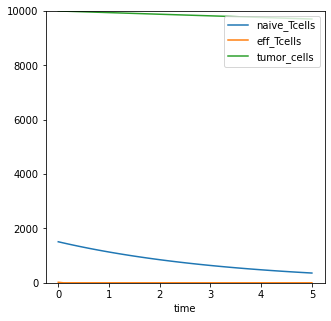

In [20]:
BioMod = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000733.3?filename=Moore_2004_fig6.xml"
# See Raw model
ctlsb = ctl.ControlSBML(BioMod)
ctlsb.plotTrueModel(figsize=(5,5))

In [ ]:
print(ctlsb.antimony)

The model is based on chronic myelogenous leukemia (CML). Based on the tumor cell population, it models tumor cell interaction with T cell and T cell activation over time. 

The porposed control output is $ {\bf tumor} $ $ {\bf cells} $ 
This is a the ideal target for the output becasuse minimizing tumor cells in the system is the ideal for cancer theraputics.

The operating point will be ${\bf 0.8} $.
This is because most species in the system settle or begin to settle around this time. Therefore it contains an adequate amount of information for which we can predict the system's behavior going forward. 

The desired operating characteristics:  The system should **settle within the first 4 seconds**, **overshoot of a magnitude of 2 at most** is ideal because, in a biological system, rapid oscillation will likely stress the cell and trigger apoptosis.The system should also have minimal oscillation.

# 2. Determine the Control Input

#### DC gain of the control input

In [22]:
time = 0.8
ctlsb = ctl.ControlSBML(BioMod, input_names=["eff_Tcells"], output_names=["tumor_cells"])
Gs = ctlsb.makeTransferFunction(time=time)
Gs

TransferFunction(array([33.83989646,  9.73971265]), array([1.        , 0.29955994, 0.00337969]))

In [23]:
Gs.dcgain()

2881.833528143124

In [24]:
Gs_BioMod = makeHRY(BioMod,"eff_Tcells", "tumor_cells", time=0.8, kp=800, ki=0, kd=0 )
print("The DC gain of the control input is", Gs_BioMod.dcgain() )

The DC gain of the control input is 0.9999995662485548


In [25]:
Gs_BioMod

TransferFunction(array([2.70719172e+04, 1.59014319e+04, 2.42559693e+03, 2.63337911e+01]), array([1.00000000e+00, 2.70725163e+04, 1.59015284e+04, 2.42559896e+03,
       2.63338025e+01]))

### The control input 

The conrtol inputs is $ {\bf Effector} $ ${\bf T-Lymphocyte } $

$ {\bf Effector} $ ${\bf T-Lymphocyte } $ denoted ***eff_Tcells*** is the control input selected for this model. The DC gain of the control input to the control output was 2881.8. Therefore our input and output should be highly controllable once processed through a controller. It is also a good species because effector T cells directly reduce tumor cell populations.

The transfer function, HRY of the input and output, was constructed to verify whether the system would be relatively simple to control and provide an idea for the optimal  control architecture. 

# 3. Design the Control System

In [26]:
def evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=0, ki=0, kd=0,
               is_plot=True,ref=1,Lim=True, noise_disturbance = False):
    """
    Run the testbed and plot the results.
    
    Parameters
    ---------
    model: str
        System under control
    input_name: str
    output_name: str
    kp: float
    ki: float
    kd: float
    is_plot: bool
    
    Results
    -------
    control.InterconnectedSystem
    plot

    """
    # Construct elements of the closed loop system
    factory = ctl.IOSystemFactory()
    
    # Create the elements of the feedback loop
    ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
    system = ctlsb.makeNonlinearIOSystem("system")
    controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
    sum_R_F = factory.makeAdder("sum_R_F")

    if noise_disturbance:
      sum_Y_N = factory.makeAdder("sum_Y_N")
      sum_U_D = factory.makeAdder("sum_U_D")
      fltr = factory.makePassthru("fltr")
      noise = factory.makeSinusoid("noise", .1, 20)
      disturbance = factory.makeSinusoid("disturbance", 0.5 , 2) 

    # Construct the Interconnected system
    system_in = "system.%s" % input_name
    system_out = "system.%s" % output_name

    if noise_disturbance:
      closed_loop = control.interconnect(
        [noise, disturbance, sum_Y_N, sum_R_F, sum_U_D, system, fltr, controller ], 
        connections=[
          ['controller.in', 'sum_R_F.out'],    # e(t)
          ['sum_U_D.in1', 'controller.out'],   # u(t)
          ['sum_U_D.in2', 'disturbance.out'],  # d(t)
          [system_in,   'sum_U_D.out'],
          ['sum_Y_N.in1', "-" + system_out ],        # y(t)
          ['sum_Y_N.in2', 'noise.out'],        # n(t)
          ['fltr.in',     'sum_Y_N.out'],
          ['sum_R_F.in1', '-fltr.out'],
        ],
        inplist=["sum_R_F.in2"],
        outlist=["sum_R_F.in2", system_in, system_out],
      )

    if not noise_disturbance:
      closed_loop = control.interconnect(
        [system, controller, sum_R_F ], 
        connections=[
          ['controller.in', 'sum_R_F.out'],    # e(t)
          [system_in,   'controller.out'],
          ['sum_R_F.in1', "-" + system_out ],        # y(t)

        ],
        inplist=["sum_R_F.in2"],
        outlist=["sum_R_F.in2", system_in, system_out],
        )     

    # Do the simulation and plot
    X0 = ctl.makeStateVector(closed_loop,start_time=0.8)

    times = ctl.makeSimulationTimes(start_time=0, end_time=10, points_per_time=10)
    # Need the initial state

    result = control.input_output_response(closed_loop, T=times, U=1, X0=X0)
    plt.plot(result.t, result.outputs[0].flatten())
    plt.plot(result.t, result.outputs[1].flatten())
    plt.plot(result.t, result.outputs[2].flatten())

    if Lim:
      plt.ylim([-1, 20])
    
    legends = ["Reference input ", "System input: %s " % input_name , "System output: %s " % output_name]
    plt.legend(legends)
    if not is_plot:
        plt.close()
    #
    return closed_loop

# Tests
interconnect_sys = evaluateDesign(is_plot=False)
assert("Interconnect" in str(type(interconnect_sys)))
print("OK!")

OK!


# 4. Evaluate the Design

## Testing Control Constants

#### Test: varying control parameters with out noise and disturbance

kp: 0.0 ki: 0.0 kd: 0.0


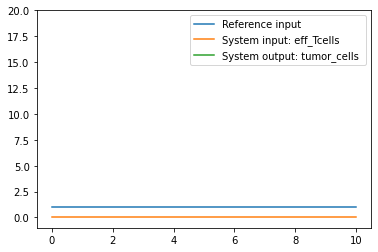

kp: 10.0 ki: 0.0 kd: 0.0


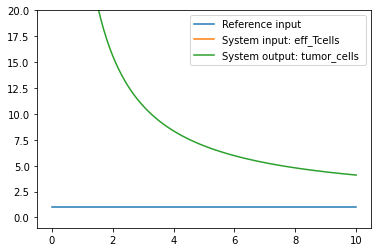

kp: 100.0 ki: 0.0 kd: 0.0


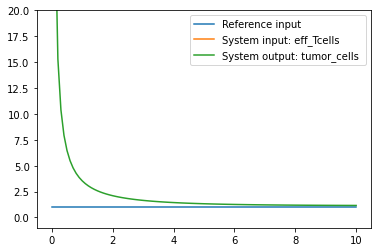

kp: 0.0 ki: 0.0 kd: 0.0


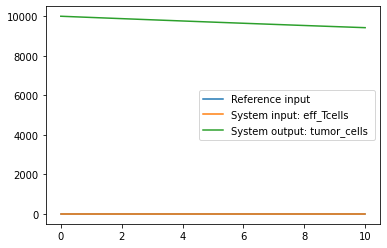

kp: 0.0 ki: -0.0 kd: 0.0


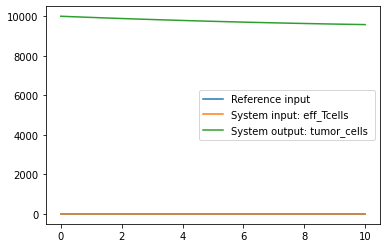

kp: 0.0 ki: 0.0 kd: 0.0


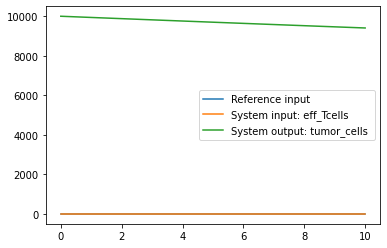

kp: 0.0 ki: 0.0 kd: 100.0


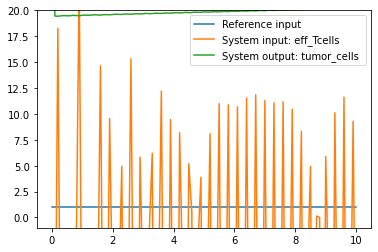

kp: 0.0 ki: 0.0 kd: 1000.0


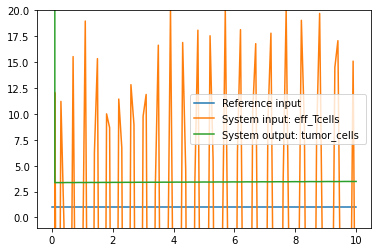

kp: 0.0 ki: 0.0 kd: 10000.0


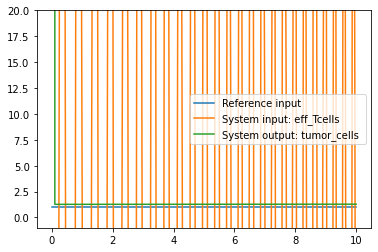

In [27]:
for kp in [0, 10, 100]:
    kd = 0;ki = 0;
    evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=kp, ki=ki, kd=kd,Lim = True)
    print("kp: %2.1f ki: %2.1f kd: %2.1f" % (kp, ki, kd))
    plt.show()
for ki in [0, -.000001, .0000001]:
    kp = 0;kd = 0;
    print("kp: %2.1f ki: %2.1f kd: %2.1f" % (kp, ki, kd))
    evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=kp, ki=ki, kd=kd,Lim=False)
    plt.show()
for kd in [100, 1000, 10000]:
    kp = 0
    print("kp: %2.1f ki: %2.1f kd: %2.1f" % (kp, ki, kd))
    evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=kp, ki=ki, kd=kd)
    plt.show()

#### Test: varying control parameters with noise and disturbance

Porportional control kp: 0.0 ki: 0.0 kd: 0.0


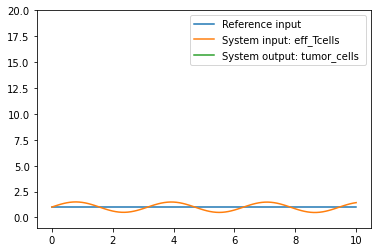

Porportional control kp: -10.0 ki: 0.0 kd: 0.0


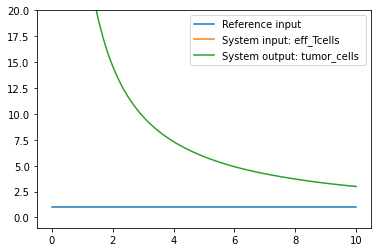

Porportional control kp: -100.0 ki: 0.0 kd: 0.0


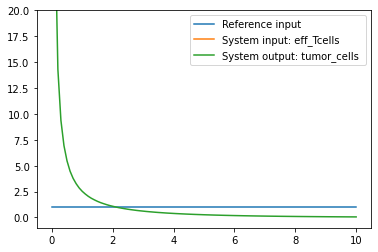

Intergal control kp: 0.0 ki: -0.0 kd: 0.0


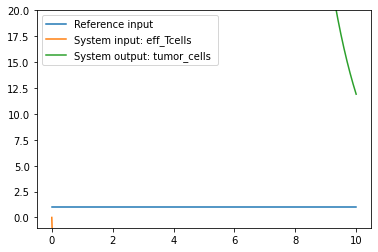

Intergal control kp: 0.0 ki: -0.0 kd: 0.0


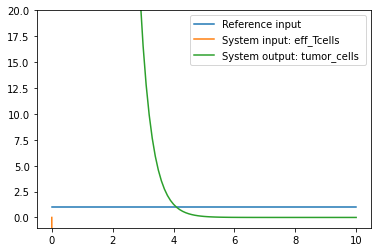

Intergal control kp: 0.0 ki: -0.1 kd: 0.0


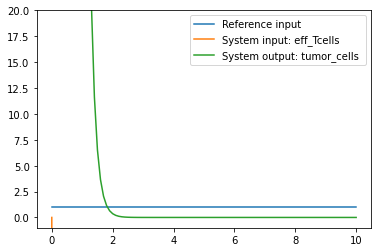

Derivative control kp: 0.0 ki: 0.0 kd: 0.0


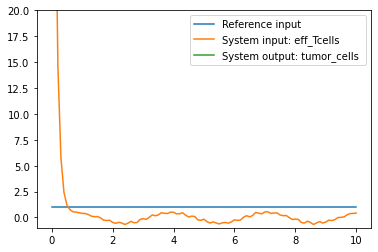

Derivative control kp: 0.0 ki: 0.0 kd: -100.0


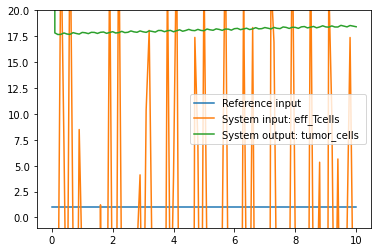

Derivative control kp: 0.0 ki: 0.0 kd: -1000.0


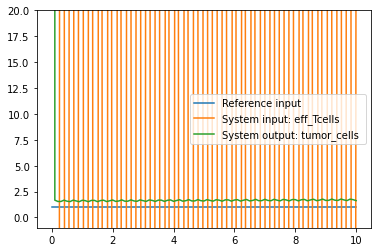

In [28]:
Axix_limit = True # Change to True to apply axis limit
for kp in [0.0001, -10, -100]:
    kd = 0;ki = 0;
    evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=kp, ki=ki, kd=kd,Lim = Axix_limit,noise_disturbance = True)
    print("Porportional control kp: %2.1f ki: %2.1f kd: %2.1f" % (kp, ki, kd))
    plt.show()
for ki in [-.001, -.01, -.05]:
    kp = 0;kd = 0;
    print("Intergal control kp: %2.1f ki: %2.1f kd: %2.1f" % (kp, ki, kd))
    evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=kp, ki=ki, kd=kd,Lim= Axix_limit,noise_disturbance = True)
    plt.show()
for kd in [0.001, -100, -1000]:
    kp = 0;ki =0;
    print("Derivative control kp: %2.1f ki: %2.1f kd: %2.1f" % (kp, ki, kd))
    evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=kp, ki=ki, kd=kd, Lim= Axix_limit,noise_disturbance = True)
    plt.show()

## Ideal control contants

#### Noise and disturbance excluded

<InterconnectedSystem:sys[182]:['u[0]']->['y[0]', 'y[1]', 'y[2]']>

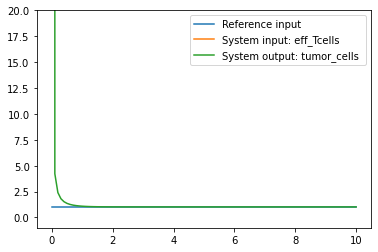

In [29]:
evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=800, ki=0, kd=0,Lim=True,ref = 1)

Proportional control of 800 adequate enough have the system output settle within 2 seconds and maintain  no bias.

#### Noise and disturbance included

<InterconnectedSystem:sys[183]:['u[0]']->['y[0]', 'y[1]', 'y[2]']>

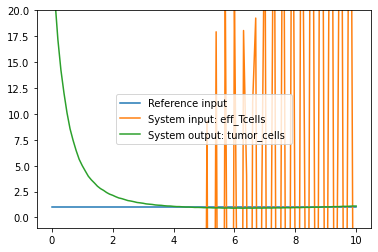

In [30]:
evaluateDesign(model=BioMod, input_name="eff_Tcells", output_name="tumor_cells", kp=-130, ki=.788, kd=-40,Lim=True,ref = 1000,noise_disturbance = True)

The ideal control constants are -130, 0.788, and -30 for proportional, integral, and derivative control, respectively. 

Disturbance affects system input by adding more prominent oscillatory behavior. However, it does not seem to substantially affect the system output (a modest effect is observed with control constants of 0) , while noise affects the system input and, to a lesser extent, the system output. It also adds instability when used exclusively with derivative control.

By adding both a large amount of proportionality controls some derivative control and a minute amount of integral control we can mitigate the disturbance and noises effects on the system input

# 5. Discuss Trade-offs

The design of the controller allows for the system input to settle within 4 seconds. However, to achieve this, we must accommodate a proportionality constant with a large magnitude of -130. It seems that for proportionality control constant larger than this will induce oscillation with large wavelengths. A relatively small and precise amount of integral control must be added simultaneously to minimize the resulting oscillation. A derivative control of -40 also helps keep the system output free of oscillation and avoid overshoot; however, it increases the settling time the larger in magnitude it is. 
For the design of this controller, the proportionality and derivative control constant were negative values. This is likely due to the high initial concentration of the system output, which is approximately  10000. Therefore, negative control constants must be used to move the system downwards towards the line to eliminate bias.